In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "true";
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]="1.00";
#os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async";
print(os.environ.get("TF_GPU_ALLOCATOR"))
print(os.environ.get("XLA_PYTHON_CLIENT_PREALLOCATE"))
import jax
import jax.numpy as jnp;
from types import SimpleNamespace;
from pathlib import Path
import numpy as np
from functools import partial
from gnlse_medium import *
from gnlse_source import *
from gnlse_solver import *
from gnlse_events import *
from gnlse_visualizations import *
import matplotlib.pyplot as plt
import gc; 
gc.collect();

jax.config.update("jax_enable_x64", True);
print(jax.devices());
jr64 = 'float64';
jc128 = 'complex128';

dev = jax.devices()[0]
stats = dev.memory_stats() 
def gb(x): return x / 1e9

print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")

None
true
[CudaDevice(id=0)]
used     : 0.0 GB
peak     : 0.0 GB
total    : 0.0 GB
largest free block: 0.0 GB


/home/josalferr/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
stats = dev.memory_stats() 
print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")


jax.clear_caches()

stats = dev.memory_stats() 
print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")

used     : 0.0 GB
peak     : 0.0 GB
total    : 0.0 GB
largest free block: 0.0 GB
used     : 0.0 GB
peak     : 0.0 GB
total    : 0.0 GB
largest free block: 0.0 GB


In [3]:
#########################################################################################
'''Spatio-temporal params: '''

Nx = Ny = 256;
Lx = Ly = 200e-6;
Lz = 1e-2;
Lt = 10e-12; # Length of time in seconds
Nt = 1; # Number of time steps
dx = Lx/Nx;
dy = Ly/Ny;


X, Y = make_space(Lx, Nx, Ly, Ny);

In [4]:
#########################################################################################
''' Refractive index profile (GRIN in this example): '''

n_core = 1.482; #n_clad = 1.451; ''' core and cladding index '''
NA = 0.200; # numerical aperture
n_clad = np.sqrt(n_core**2 - NA**2); # cladding index from NA
print("n_clad: ", n_clad)
r_core = 50e-6; ''' core radius '''
alpha = 2.0; ''' Index profile exponent (alpha = 2 for parabolic GRIN) '''

#nxy = make_supergauss_index(X, Y, n_core = n_core, n_clad = n_clad, r_core = r_core, m =20);
nxy = make_polynomial_n(X, Y, n_core = n_core, n_clad = n_clad, r_core = r_core, alpha = alpha);
n_xyomega = jnp.tile(nxy[:,:,None], (1,1 , Nt));

n_clad:  1.468442712535971


In [5]:
###########################################################################################
''' Solve for modes; comment outR,R if folder is already populated:
(Note: Modes specific to particular Lx, Nx, Ly, Ny -> X, Y grid!):
(Note:  n_ref is usually the core index, n_core): '''

lambda0 = 1030e-9; ''' 1030 nm '''
n_modes = 200;
folder = Path("GRIN_modes"); 

''' Comment out when folder populated '''
#solve_modes(n_xy=nxy, n_ref = n_core, x = X[:, 0], y = Y[0, :], lambda0 = lambda0,
#            n_modes = n_modes, folder = folder, maxiter = 5000, tol = 1e-9);

' Comment out when folder populated '

In [6]:
############################################################################################
''' Build a field from the discovered modes: '''

weights_init = {42: 2.0 + 1j/2, 99: 1.0 + 1.6j/2} #, 100: 1.0 + 1j/2, 101: 1.0 + 1j/2, 102: 1.0 + 1j/2,};
field_unscaled, indices, coeffs = make_source_from_files(folder="GRIN_modes", heading="mode", file_format = "npz", weights = weights_init);
E_xy, weights = norm_scale_field_weights(field_unscaled, indices, coeffs, power = 1.0, dx = dx, dy = dy);

[3162.27766017+0.j]
(256, 256, 1)


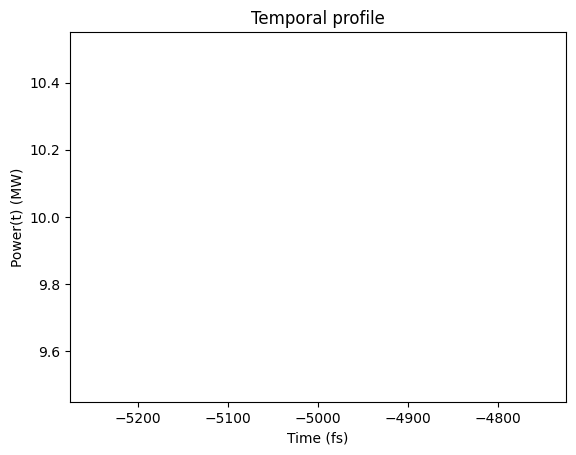

In [7]:
############################################################################################
power = 10e6; ''' 20 MW '''

''' Define temporal profile '''
phis = 0.0;
t0 = 0.0;
fwhm = 120e-15; ''' 120 fs '''
phase = 0.0;
omega0 = 2 * jnp.pi / lambda0; ''' Carrier frequency in rad/s '''
T = jnp.linspace(-Lt/2, Lt/2, Nt); # time grid`

#E_t = cw_temp_profile(jnp.array(lambda0, dtype = jnp.float64), phis, Lt=Lt, Nt=Nt);
#E_t = gaussian_pulse_profile(t0, fwhm, Lt, Nt, carrier_omega=omega0, phase=phase)
lambdas = jnp.array([1030e-9])
phis    = jnp.array([0.0])
E_t_cw  = cw_temp_profile_freq(lambdas, phis, Lt, Nt)
# Gaussian: 150 fs FWHM, centered at t0=0, with a carrier shift
#E_t_gauss = gaussian_pulse_profile_freq(t0=0.0, fwhm=150e-15, Lt=Lt, Nt=Nt, carrier_omega=0.0, phase=0.0)

E_t = jnp.sqrt(power) * E_t_cw;
print(E_t)

plt.figure();
plt.plot(T * 1e15, np.abs(E_t)**2 / 1e6);
plt.xlabel("Time (fs)"); plt.ylabel("Power(t) (MW)");
plt.title("Temporal profile");

field = combine_spatial_temporal(E_xy, E_t) ;
print(jnp.shape(field));

power:  10.0  MW


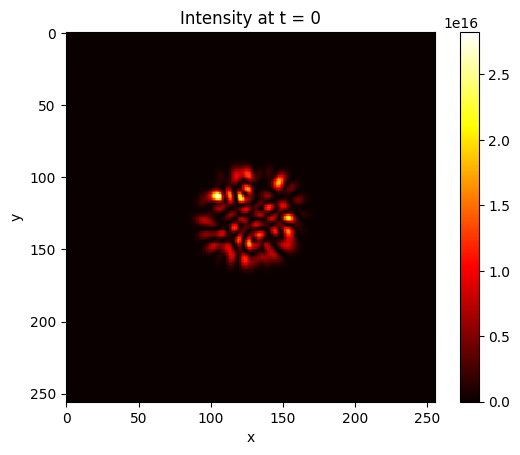

In [8]:
t_index =  int(Nt / 2); # Time index to visualize
I_xy = jnp.real(field[:, :, t_index])**2 + jnp.imag(field[:, :, t_index])**2
P_xy = jnp.sum(I_xy) * dx * dy;
print("power: ", P_xy / 1e6, " MW");


plt.figure()
plt.imshow(I_xy, cmap='hot', interpolation='nearest');
plt.colorbar();
plt.title(f"Intensity at t = {t_index}");
plt.xlabel("x");    plt.ylabel("y");
plt.show();

In [9]:
#############################################################################################
''' Define remaining params: '''
c = 2.998e8;
beta0 = n_core * 2 * jnp.pi / lambda0;
print("beta0: ", beta0);
n_g = 1.468; # group index
beta1 = n_g / c;
beta2 = 22e-27; # 1.0; # Dispersion coefficient in s^2/m
n2 = 2.22e-20; ''' 2.22e-20 m^2/W '''
omega = None;

pml_thickness = 40e-6;
pml_Wmax = 1e12;
''' args '''



beta0:  9040466.626446744


' args '

In [10]:
# override from previous cells:
Lz = 5e-2; # Length of propagation in z
save_at = jnp.linspace(0, Lz, 1000, endpoint=True); # save at these positions in z
print(save_at)
n2 = 5e-21

##########
args = {"Lx" : Lx, "Ly": Ly, "Lz": Lz, "Lt": Lt,   # spatiotemporal dimensions
        "Nx": Nx, "Ny": Ny, "Nt": Nt,              # spatial and temporal grid
        "n_xyomega": n_xyomega, "n2": n2, "nref": n_clad, # potential params
        "beta0": beta0, "beta1" : beta1,       # propagation params
        "beta2": beta2, "lambda0": lambda0,    # propagation params
        "save_at": save_at,                   # array of z positions to save at
        "deltaZ": 1e-6,                       # linear step size
        "deltaZ_NL":1e-5,                      # nonlinear step size
        "saturation_intensity": 5e-5,          #
        "gain_coeff": 0.0,
        "gain_fwhm": 0.0,
        "t1": 12.2e-15, "t2": 32e-15,       
        "pml_thickness": pml_thickness, "pml_Wmax": 10.0e12, # pml_Wmax,
        "fr": 0.0, "sw": 0                   # raman fraction (0.0 for no raman) and 
       };

stats = dev.memory_stats() 
print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")

[0.00000000e+00 5.00500501e-05 1.00100100e-04 1.50150150e-04
 2.00200200e-04 2.50250250e-04 3.00300300e-04 3.50350350e-04
 4.00400400e-04 4.50450450e-04 5.00500501e-04 5.50550551e-04
 6.00600601e-04 6.50650651e-04 7.00700701e-04 7.50750751e-04
 8.00800801e-04 8.50850851e-04 9.00900901e-04 9.50950951e-04
 1.00100100e-03 1.05105105e-03 1.10110110e-03 1.15115115e-03
 1.20120120e-03 1.25125125e-03 1.30130130e-03 1.35135135e-03
 1.40140140e-03 1.45145145e-03 1.50150150e-03 1.55155155e-03
 1.60160160e-03 1.65165165e-03 1.70170170e-03 1.75175175e-03
 1.80180180e-03 1.85185185e-03 1.90190190e-03 1.95195195e-03
 2.00200200e-03 2.05205205e-03 2.10210210e-03 2.15215215e-03
 2.20220220e-03 2.25225225e-03 2.30230230e-03 2.35235235e-03
 2.40240240e-03 2.45245245e-03 2.50250250e-03 2.55255255e-03
 2.60260260e-03 2.65265265e-03 2.70270270e-03 2.75275275e-03
 2.80280280e-03 2.85285285e-03 2.90290290e-03 2.95295295e-03
 3.00300300e-03 3.05305305e-03 3.10310310e-03 3.15315315e-03
 3.20320320e-03 3.253253

In [ ]:
results = GNLSE3D_propagate(args, field); 

used     : 1.054354688 GB
peak     : 3.15885696 GB
total    : 0.0 GB
largest free block: 0.0 GB
(256, 256, 1, 1000)
power:  10.000000000086512  MW


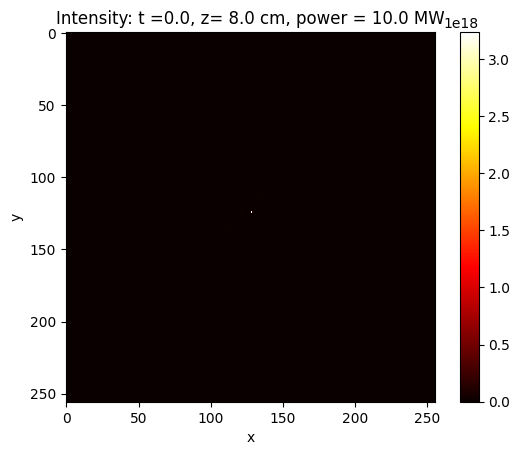

In [ ]:
stats = dev.memory_stats() 
print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")

slot = -1; # Last save slot
time = 0; # Time slot to visualize
print(results["field"].shape);

res_field = results["field"][:, :, time, slot];

I_xy = jnp.real(res_field)**2 + jnp.imag(res_field)**2
P_xy = jnp.sum(I_xy) * dx * dy;
print("power: ", P_xy * 1e-6 , " MW");

plt.figure();
plt.imshow(I_xy, cmap='hot', interpolation='nearest');
plt.colorbar();
plt.title(f"Intensity: t ={time * Lt/Nt}, z= {round(save_at[slot], 3)*100} cm, power = {round(P_xy * 1e-6, 2)} MW");
plt.xlabel("x");    plt.ylabel("y");
plt.show();

In [ ]:
# Create an animation of the field intensity over time
#gif_path = make_xy_z_animation(results["field"], t_index=-1, quantity='intensity', norm='per_frame',
#                               fps=50, filename='xy_z_CW_beam_cleaning.gif')
#print("Saved animation to:", gif_path)


Saved animation to: xy_z_CW_beam_cleaning.gif


In [ ]:
# P(t) = ∬ |E(x,y,t,z=Lz)|^2 dx dy
P_out = np.sum(np.abs(np.asarray(results["field"][..., -1]))**2, axis=(0,1)) * dx * dy
rel_std = P_out.std() / P_out.mean()
print("Relative std of P(t):", rel_std)


Relative std of P(t): 0.0


In [ ]:
info = compute_self_focusing_pixel_intensity(10e6, n2, dx, dy, safety=0.5, include_delta_n_cap=True);
I_thresh = info['I_thresh']
print("threshold intensity:", I_thresh);

def collapse_event(field_xyt, z, payload):
    return jnp.max(jnp.abs(field_xyt)**2) > I_thresh;

threshold intensity: 2.9e+18


In [ ]:
results_prime = GNLSE3D_propagate(
    args, field,
    event_fn=collapse_event,
    event_payload={'I_thresh': I_thresh},  # W/m^2
    stop_on_event=True,
    event_check_every=1
)
print(results_prime['stopped_early'], results_prime['z_event'])

True 0.37323


used     : 2.109231872 GB
peak     : 4.212686336 GB
total    : 0.0 GB
largest free block: 0.0 GB
(256, 256, 1, 1000)
power:  10.000000000054223  MW


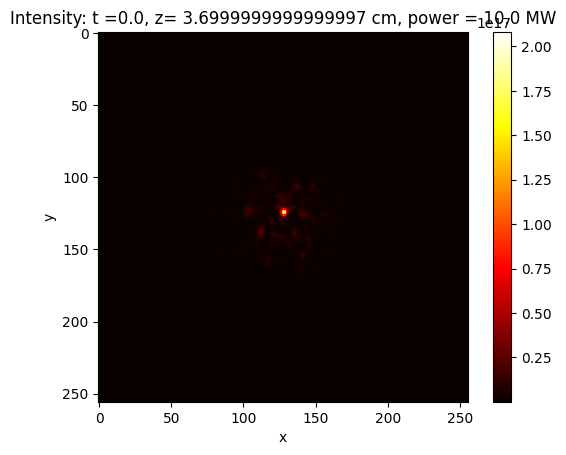

In [ ]:
stats = dev.memory_stats() 
print("used     :", gb(stats.get("bytes_in_use", 0)), "GB")
print("peak     :", gb(stats.get("peak_bytes_in_use", 0)), "GB")
print("total    :", gb(stats.get("total_device_memory", 0)), "GB")
print("largest free block:", gb(stats.get("largest_free_block_bytes", 0)), "GB")

slot = 465; # Last save slot
time = 0; # Time slot to visualize
print(results_prime["field"].shape);

res_field_p = results_prime["field"][:, :, time, slot];

I_xy = jnp.real(res_field_p)**2 + jnp.imag(res_field_p)**2
P_xy = jnp.sum(I_xy) * dx * dy;
print("power: ", P_xy * 1e-6 , " MW");

plt.figure();
plt.imshow(I_xy, cmap='hot', interpolation='nearest');
plt.colorbar();
plt.title(f"Intensity: t ={time * Lt/Nt}, z= {round(save_at[slot], 3)*100} cm, power = {round(P_xy * 1e-6, 2)} MW");
plt.xlabel("x");    plt.ylabel("y");
plt.show();